# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- l-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 25th of november at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 25 novembre 2018**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "soufiane"
ln1 = "moutei"
fn2 = "mohammed"
ln2 = "barrahma-tlemcani"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_moutei_soufiane_and_barrahma-tlemcani_mohammed.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [3]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [4]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


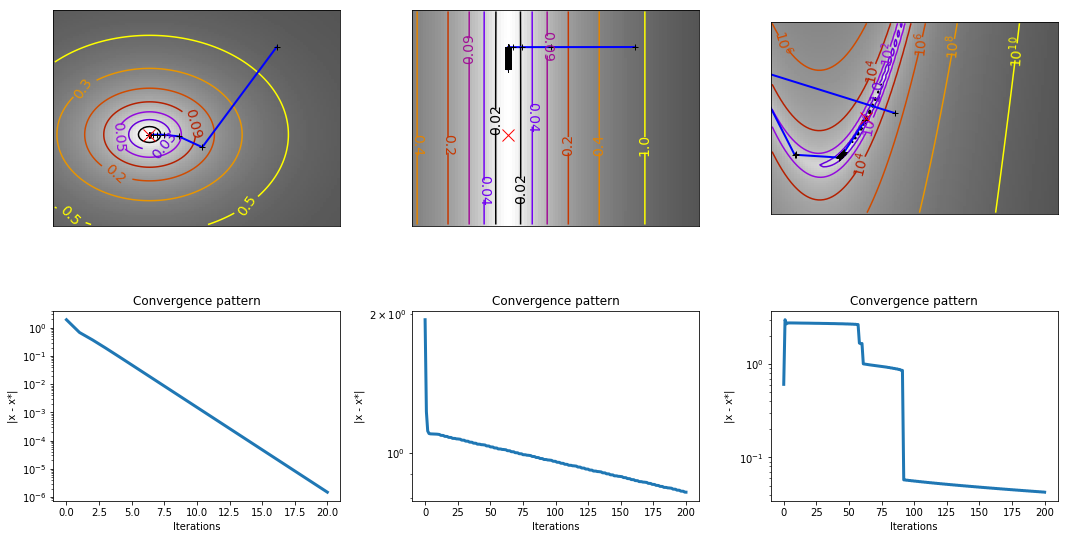

In [5]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non convex Gaussian kernel ($f(x) = -\exp(-x^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 2: Implement Newton method

Implement Newton's method. Beware that the Hessian SHOULD be regularized !

**You are expected to comment** what you see. Play with the parameters. Do not describe the curves, rather

In [6]:
from scipy import linalg
from scipy.sparse.linalg import cg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    c2 = 0.95
    max_iter = 100
    lambda_threshold = 0.0001    # regularization threshold
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        #######################################################################
        # Compute the Hessian, regularize it and compute the search direction d
        # TODO H = ..
        H = f_hessian(x)
        
        # Regularization
        min_eigval_H = np.linalg.eigvalsh(H).min()
        if (min_eigval_H < lambda_threshold):
            H += (lambda_threshold - min_eigval_H) * np.eye(H.shape[0])
        
        # Compute the search direction d
        if (k > 1):
            d = - cg(H, grad_x, d)[0]
        else:
            d = - cg(H, grad_x)[0]
        
        ########################################################################
        
        
        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


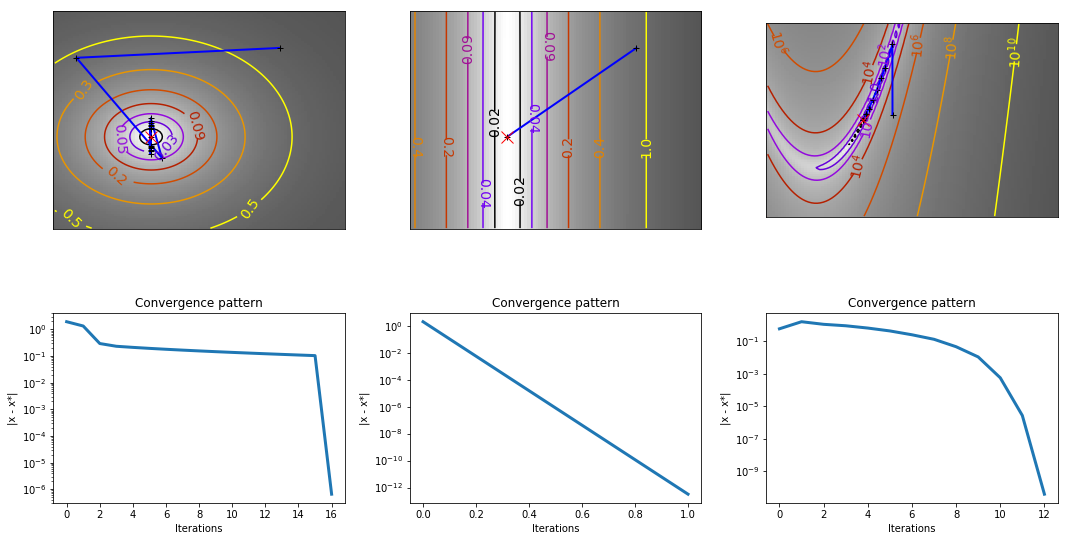

In [7]:
test_solver(newton)

## Comments

As we saw in class, for a quadratic problem, Newton's Method converges in one step, that explains why the algorithm converged in one step for the second function. For the 1st and the 3rd functions, the algorithms requires more iterations because the functions are not quandratic, but the number of iterations is much lower (especially for the 3rd function) compared to Gradient Descent thanks to the line search method in the direction $d = −\nabla^2 f(x_k)^{−1} \nabla f(x_k)$.

# Part 2: Implement DFP algorithm

Now, implement the DFP algorithm using the formula for $B$ in the slides.

**Comment on what you observe**. Focus on the explanation, not on describing the curves! 

Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?

In [8]:
def dfp(x0, f, f_grad, f_hessian, reinit_period=False):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       

        # Compute the search direction
        d = np.dot(B, -grad_x)
        
        if (reinit_period and k%len(x) == 0):
            d = -grad_x

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation
        
        # TODO B = ...
        first_term = s.reshape(-1, 1).dot(s.reshape(1, -1)) / s.dot(y)
        second_term = B.dot(y.reshape(-1, 1)).dot(y.reshape(1, -1).dot(B)) / y.T.dot(B.dot(y))
        B += first_term - second_term
        ################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


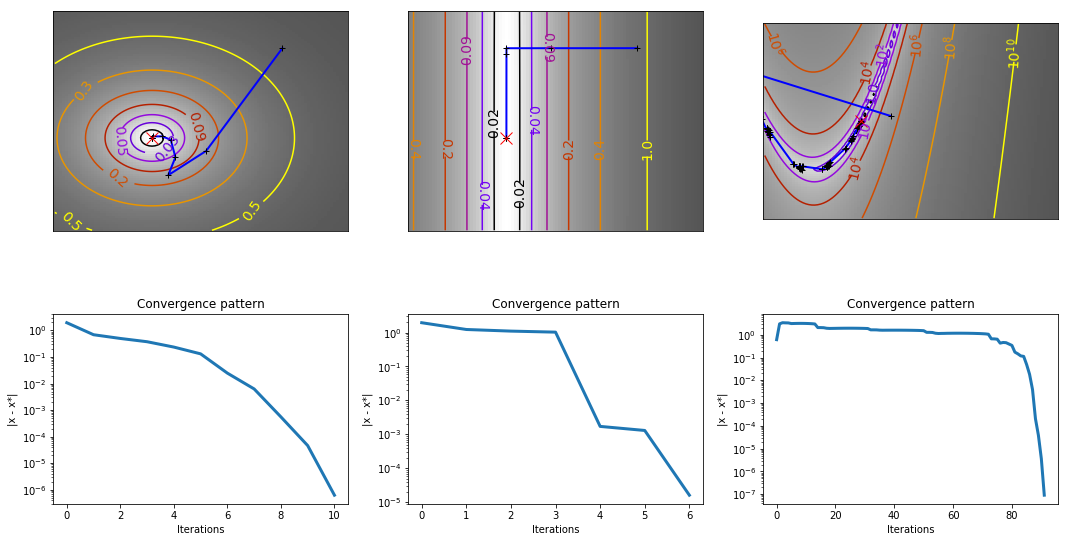

In [9]:
test_solver(dfp)

## Comments

For the quadratic function (2nd one), the algorithm is **supposed to converge in 2 iterations**. However, it required 6 iterations to converge due to the line search method that doesn't return an exact optimal step. 

For non quadratic functions (1st and 3rd ones), the convergence depends on the estimation of the curves. We can see that this estimation was worse than the one given by the Hessian for the 3rd function which led to a slower convergence. The opposite happened for the first function. However, **if the direction $d_k$ is reinitialized to $−g_k$ periodically**, the algorithm converges to a local minimum $x^\star$ of the function $f$ and $\lim_{k \to \infty} B_k = \nabla^2 f(x^\star)^{-1}$. We added a parameter *reinit_period* to the function to do this, let's try it:


Running solver on case 1

Running solver on case 2

Running solver on case 3


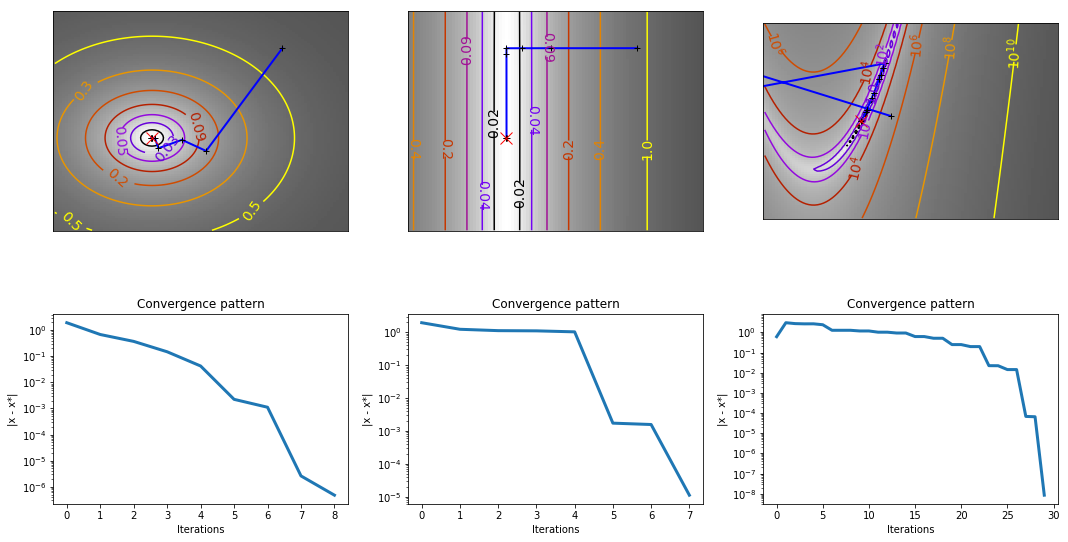

In [10]:
test_solver(lambda x0, f, f_grad, f_hessian: dfp(x0, f, f_grad, f_hessian, reinit_period=True))

If we focus only on the non-quadratic functions (1st and 3rd ones), we can see that the convergence is faster (much faster for the 3rd function) than without applying a periodic re-initiliazation, because close to the optimum, if the line search is exact, the method behaves similarly to the Newton method.

# Part 3: Implement BFGS algorithm

You should now implement BFGS, using the formula for $B_t$ seen in the slides.

**Comment** on what you see.

In [11]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        #d = -np.dot(B, grad_x)
        
        if (k > 1):
            d = - cg(B, grad_x, d)[0]
        else:
            d = - cg(B, grad_x)[0]

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation
        
        # TODO B = 
        
        first_term = y.reshape(-1, 1).dot(y.reshape(1, -1)) / y.T.dot(s)
        second_term = B.dot(s.reshape(-1, 1)).dot(s.reshape(1, -1).dot(B)) / s.T.dot(B.dot(s))
        B += first_term - second_term
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


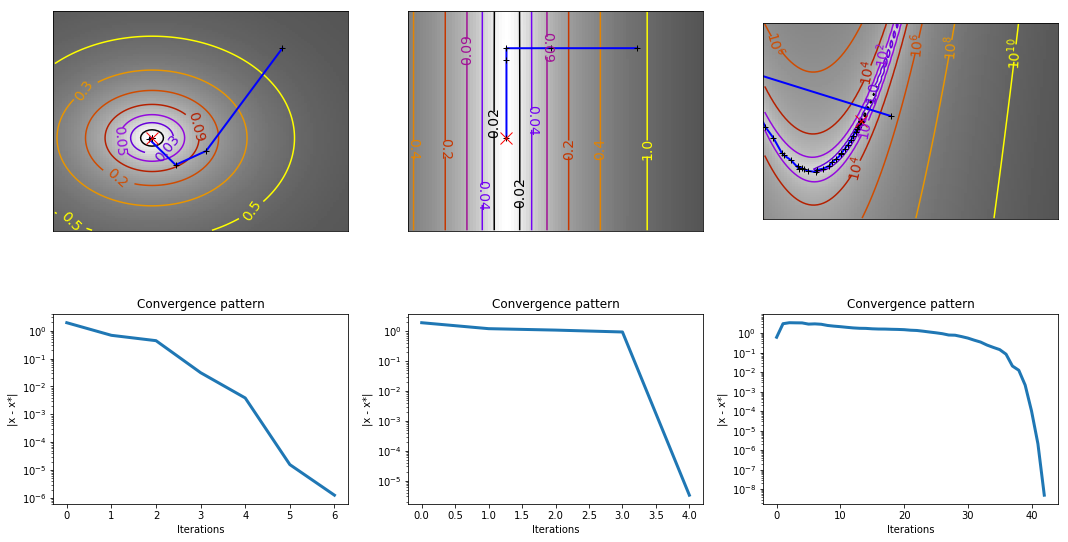

In [12]:
test_solver(bfgs)

## Comments

DFP and BFGS are dual to each other. They have both the same property that for quadratic functions, the convergence has to be in 2 iterations in our case. However, for the same reason as DFS, the line search method doesn't return an exact optimal step which led to a convergence in 4 iterations for the 2nd function. But, BFGS converges faster than DFP because it's less sensitive to the use of line search method.

For the non-quadratic functions (1st and 3rd one), the convergence is faster than DFP because BFGS convergence speed is much less sensitive to the use of approximate step size. 

For the third function, the use of period re-initialization gave better results for DFP. In fact, if we do the same with BFGS, we can obtain a convergence in 25 iterations.

# Part 3: Implement l-BFGS algorithm

You should now implement the l-BFGS algorithm. First, code the two-loops recursion:

In [13]:
def two_loops(grad_x, m, s_list, y_list, rho_list, B0):
    '''
    Parameters
    ----------
    
    grad_x : ndarray, shape (p,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    rho_list : list of length m
        the past m values of rho
        
    B0 : ndarray, shape (p, p)
        Initial inverse Hessian guess
    
    Returns
    -------
    
    r :  ndarray, shape (p,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = np.zeros(m)
    # TODO : first loop
    for i in range(m-1, -1, -1):
        alpha_list[i] = rho_list[i] * s_list[i].T.dot(q)
        q -= alpha_list[i] * y_list[i]
        
    r = np.dot(B0, q)
    # TODO: second loop
    for j in range(m):
        beta = rho_list[j] * y_list[j].T.dot(r)
        r += (alpha_list[j] - beta) * s_list[j]
        
    return -r

In [14]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 5
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    y_list, s_list, rho_list = [], [], []
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = two_loops(grad_x, min(m, len(s_list)), s_list, y_list, rho_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        rho = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        rho_list.append(rho)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            rho_list.pop(0)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


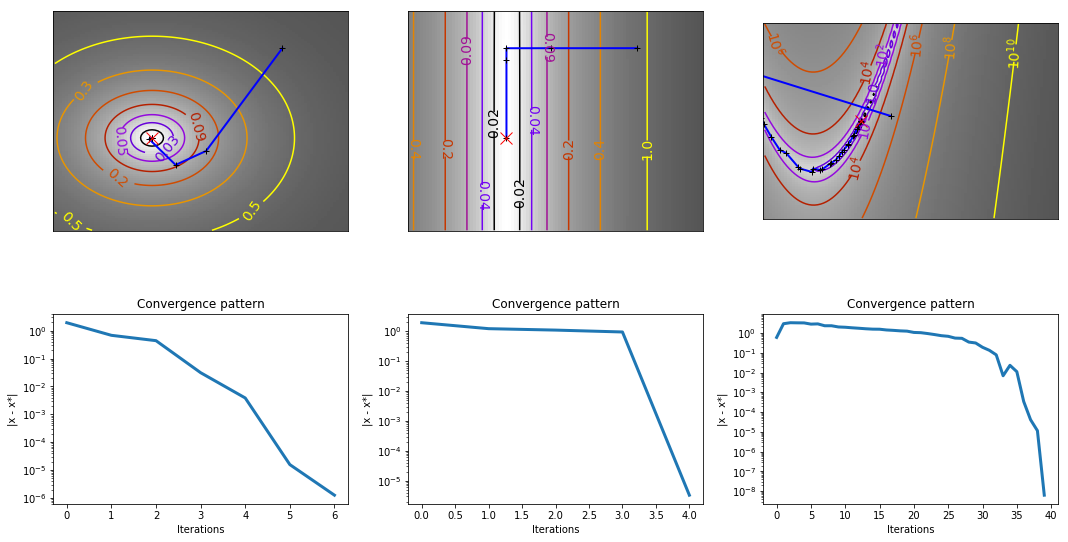

In [15]:
test_solver(lbfgs)

## Comments

The results change a little bit if we change the value of the memory size $m$. We changed its value to $m=5$. L-BFGS is faster than BFGS (even if they have almost the same number of iterations), because like the latter, L-BFGS doesn't need an exact line search to converge, and better than that, it has a low memory cost.